# Welcome to Santiment KDD Hand-on Tutorial!

**In this tutorial you'll:**
1. Practice getting different data for the analysis
2. Learn one way to extract addresses' features
3. Get time to explore the data by yourself

## Prepare the stuff

In [1]:
# imports
from clickhouse_driver import Client
import san
from san import Batch
import pandas as pd

In [2]:
# create ClickHouse client
HOST = 'clickhouse-0'
COMPRESSION = 'lz4'
client = Client(host = HOST, compression = COMPRESSION)

In [3]:
# (optional) configure your API key
san.ApiConfig.api_key = 'api-key-provided-by-sanbase'

In [4]:
# Create universal plot drawer for fast vizualizations of 2 metrics
# We'll need that later

import matplotlib.pyplot as plt

def fancy_plot(df, metric_1, metric_2):

    fig, ax1 = plt.subplots(figsize=(20,10))

    # draw metric_1
    p1, = ax1.plot(df.index, df[metric_1],
                   color = 'darkblue', label = metric_1, linewidth=2)
    plt.ylim(0)
    plt.grid(axis = 'x')
    ax1.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax1.set_ylabel(metric_1, fontsize = 16, color = 'darkblue')
    plt.yticks(fontsize = 14)
    plt.xticks(fontsize = 14)

    # draw metric_2
    ax2 = ax1.twinx()
    ax2.plot(df.index,
             df[metric_2],
             color = 'green', label = metric_2)
    ax2.fill_between(df.index,
                     df[metric_2],
                     facecolor='lightgreen', alpha=0.25)
    
    ax2.set_ylabel(metric_2, fontsize = 16, color = 'darkgreen')
    plt.ylim(0)
    plt.yticks(fontsize = 14)
    plt.xlim(right=df.index[-1], left=df.index[0]) 
    
    fig.patch.set_facecolor('#5182B210')

## Compare ETH DAA to ETH Price

Lets try to make any hypothesis around the Eth price. Are there any facors which influence the price? <br>
Based on theories like [Network effect](https://en.wikipedia.org/wiki/Network_effect) or [Metcalfe's law
](https://en.wikipedia.org/wiki/Metcalfe%27s_law) it's possible to assume that price of the network depends on number of it's participants. We can measure such number using number of **daily active addresses**. Lets check this assumption with Ether and it's network.

In [5]:
# choose parameters 
from_date = "2017-01-01"
interval = '1d'

# get the data
batch = Batch()

daa = batch.get(
    "daily_active_addresses/ethereum",
    from_date = from_date,
    interval = interval
)
prices = batch.get(
    "prices/ethereum",
    from_date = from_date,
    interval = interval
)

[daa, prices] = batch.execute()

# join dataframes (using 'dt' set as index)
eth = prices.join(daa)[['priceUsd', 'activeAddresses']]

#take a look
eth.head()

#you could compute DAA by hands using ClickHouse but SanPy looks more simple:)  

,priceUsd,activeAddresses
datetime,,
2017-01-01 00:00:00+00:00,8.237229,13762
2017-01-02 00:00:00+00:00,8.220955,14982
2017-01-03 00:00:00+00:00,8.939689,14535
2017-01-04 00:00:00+00:00,10.619362,17600
2017-01-05 00:00:00+00:00,10.793949,18489


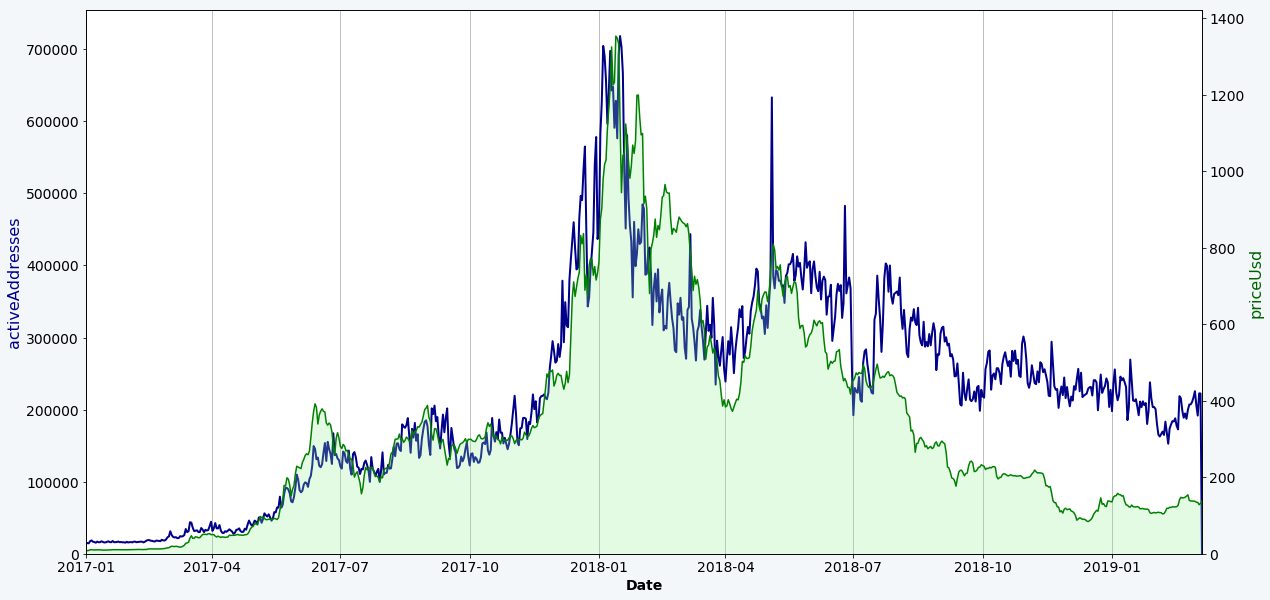

In [6]:
# compare DAA againt the Price
fancy_plot(eth, metric_1 = 'activeAddresses', metric_2 = 'priceUsd')

## Comapre ETH Social Volume to DAA

The hypothesis about SocialVolume and DAA is that peole speak much about the project when making any transactions. So potentially we could observe correlation between socialVolume and DAA. (it's just a hypothesis, remember about false correlation)

In [7]:
# use same parameters 
sv = san.get(
    "social_volume/ethereum",
    from_date = from_date,
    interval = interval,
    social_volume_type="TELEGRAM_CHATS_OVERVIEW"
)

# join dataframes (using 'dt' set as index)
eth = eth.join(sv)

# take a look 
eth.head()

,priceUsd,activeAddresses,mentionsCount
datetime,,,
2017-01-01 00:00:00+00:00,8.237229,13762,4
2017-01-02 00:00:00+00:00,8.220955,14982,13
2017-01-03 00:00:00+00:00,8.939689,14535,17
2017-01-04 00:00:00+00:00,10.619362,17600,45
2017-01-05 00:00:00+00:00,10.793949,18489,17


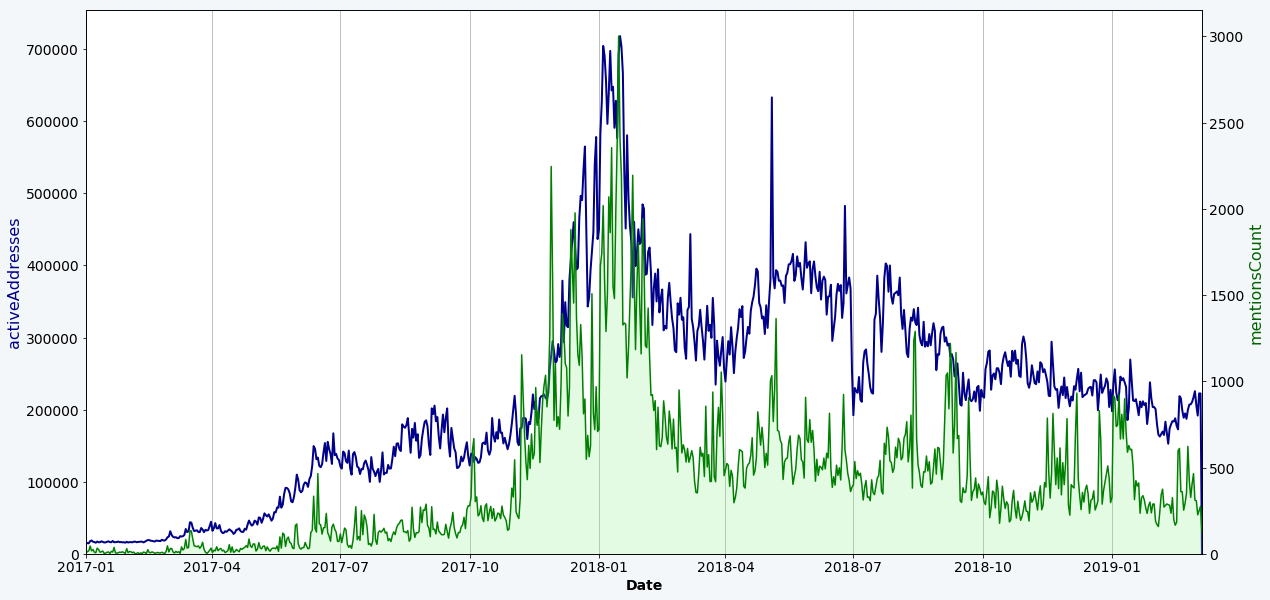

In [8]:
# compare SocialVolume againt DAA
fancy_plot(eth, metric_1 = 'activeAddresses', metric_2 = 'mentionsCount')

In [9]:
# check correlation matrix
# drop last line (DAA cant be computed for current day yet) 
eth[:-1].corr()

,priceUsd,activeAddresses,mentionsCount
priceUsd,1.000000,0.838452,0.750607
activeAddresses,0.838452,1.000000,0.816861
mentionsCount,0.750607,0.816861,1.000000


To be honest daily data is quite noisy. Smoothing the data you can achive even better visual experience and higher correlation coefficients but smoothing the data always causes data loss. 

## Custom Metrics

You can create any custom metric depending on your needs. Here we suggest a kind of signal metric: amount of large transfers in the network. We'll use GNT token as an example. 

### Number of outstanding transfers

In [10]:
# choose parameters 
from_date = '2017-04-01'
interval = '1d'

# get the data
price = san.get(
    "prices/golem-network-tokens",
    from_date = from_date,
    interval = interval
)

# change dt format  
price.index = price.reset_index().datetime.dt.date

# take a look
price.head()

,marketcap,priceBtc,priceUsd,volume
datetime,,,,
2017-04-01,7.170774e+07,0.000081,0.087448,1636680
2017-04-02,7.011892e+07,0.000079,0.085511,2668190
2017-04-03,6.495784e+07,0.000070,0.079217,1708640
2017-04-04,6.307457e+07,0.000067,0.076920,1286810
2017-04-05,6.401714e+07,0.000069,0.078070,1035050


In [11]:
# get daily transfers of GNT token with value grater than 2M GNT

# create the query
sql = """
SELECT uniqExact(transactionHash), toStartOfDay(dt)
FROM erc20_transfers
PREWHERE dt > toDate('{}')
    AND contract = '0xa74476443119a942de498590fe1f2454d7d4ac0d'
WHERE value/pow(10,18) > 2e6
GROUP BY toStartOfDay(dt)
ORDER BY toStartOfDay(dt)
""".format(from_date)

# execute the query
df = client.execute(sql)

# reformat as pd.DataFrame
df = pd.DataFrame(df, columns = ['trx', 'dt'])

In [12]:
# merge price and transfers dataFrames 
df = price.join(df.set_index('dt'))

# there are some NANs in 'trx' column caused by joining daily price and non-daily large transfers
# there are days when there aren't any large transfers, fill it with 0.
df = df.fillna(0)

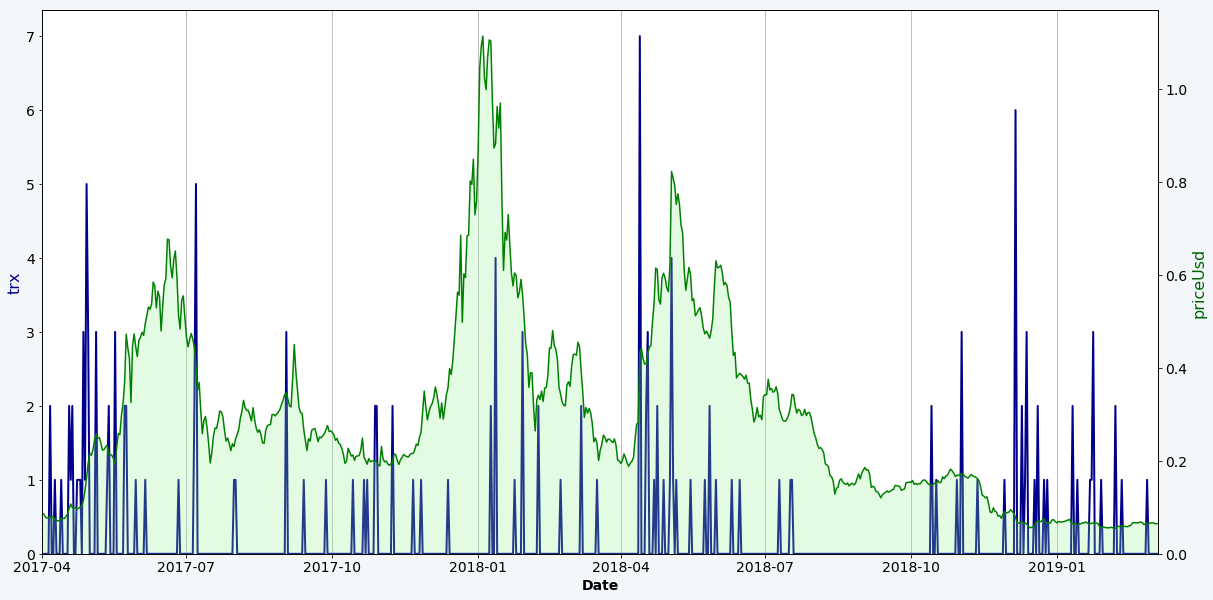

In [13]:
fancy_plot(df, 'trx', 'priceUsd')

That particular metric may be used as a signal in your analysis. Obviusly it cant be 100% accurate but it may be a valuable datapoint. 

Except large transfers it's possible to compute the number of transfers to/from the group of predefined addresses. Imagination is endless:-)

# Computing Addresses' Features

### Addresses' features

Previously we've concentrated on general blockchain features only. But it's possible to extract features for particular addresses. In this section we'll introduce you a few basic addresses' features that could be computed using onchain data. 

Firstly lets us describe features we gonna calculate.

### 1. **Number of transactions.**

For every address it's possible to calculate number of trasaction it participated in. Going further it's possible to compute number of incoming and outcoming trasactions, transaction with Ether and ERC20 tokens. So we get 4 basic features:
    <ul>
    <li> Number of incoming Ether transfers;
    <li> Number of outcoming Ether transfers;
    <li> Number of incoming ERC20 transfers;
    <li> Number of outcoming ERC20 transfers
    </ul>

Using this it's possible to compute:  
    <li> Number of all incoming transfers;
    <li> Number of all outgoing transfers;
    <li> Number of all ERC20 transfers;
    <li> Number of all Ether transfers;
    <li> Number of all transfers. <br>
    just computing the summ of first 4 features.

### 2. **Number of contacts.**
        
We call address' counterparty in a transactions as *contact*. Imagine Alice and Bob made transfers between each other and Alice didnt make any other transactions. Alice's address has 10 transaction in total but only 1 counterparty, e.g. 1 address in contact.
        
So we can compute similar features as for number of transactions but for contacts, i.e.
    <li> Number of incoming Ether contacts;
    <li> Number of outcoming Ether contacts;
    <li> Number of incoming ERC20 contacts;
    <li> Number of outcoming ERC20 contacts;
    <li> Number of all incoming contacts;
    <li> Number of all outgoing contacts;
    <li> Number of all ERC20 contacts;
    <li> Number of all Ether contacts;
    <li> Number of all contacts. 
        
In other words, *'number of all contacts'* is the number of unique addresses that given address transacted. <br>
*'number of all outgoing contacts'* is the number of unique addresses that given address sent funds to. etc. Hope you got the idea:) 

        
Note that we cant just compute the summ of first 4 numbers to get total number of contacts. <br>Imagine Alice made 5 transactions to Bob and Bob made 5 transactions to Alice. Alice's address has 1 outcoming contact, 1 incoming contact and 1 contact in total.
        

### 3. **Date of last and first transaction.**
        
Also possible to split accross inc/out, eth/erc20 transactions. 
      

  
### 4. **Number of tokens (contracts) the address ever touched.**
        
Imagine a trader's address. He transacted with dozens of different tokens. The number of different tokens went through the address is a nice feature to have
        
        
        
*It's not the coplete list of possible features. Needed features depend on your goals and desires so feel free to discover any other features!*

_____________________

### Tips and tricks

Also note that computing such features requires a plenty of resources. You have a common server with other participants so please do not try to compute all possible features for all addresses simultaneously. It just kills the server:) 

Last thing to talk about is that algorithm optimization does matter. One way to speed up computations is using **temporary ClickHosue tales**. 

The idea behind using temporary table is to relieve computations on server. Temporary table are created for the client session. Temporary tables disappear when the session ends, including if the connection is lost. 

You'll see code examples below. 

[See ClickHouse documentations for more info](https://clickhouse.yandex/docs/en/query_language/create/#temporary-tables)

### **Hands-on!**

In this tutorial we'll show the way to compute some of described above features for all addresses being active withing last block (i.e. all addresses sent or received any tranfers in the last block) excluding miners' addresses. 

In [14]:
# create temporary clickHouse table for addresses to get features from
sql_create_temp_addresses = """
CREATE TEMPORARY TABLE temp_addresses ( 
    address String
)"""

# execute the query
client.execute(sql_create_temp_addresses)


# fill 'temp_addresses' addresses table with all addresses being active in the last block.
    # to achive that you have to join results from eth_transfers and erc20_transfers tables
    # also lets ignore all miner addresses (check last 'WHERE' clause)
    # also filter out 'mining block' which is a service abstraction - 
        # reward_per_block is set as a transaction from 'mining_block' to miner 
        
sql_fill_temp_addresses = """
INSERT INTO temp_addresses(address)
SELECT distinct address
FROM (
    SELECT arrayJoin([from, to]) as address
    FROM eth_transfers 
    WHERE type = 'call'
        AND blockNumber = (SELECT max(blockNumber) FROM eth_transfers)
    UNION ALL
    SELECT arrayJoin([from, to]) as address
    FROM erc20_transfers 
    WHERE blockNumber = (SELECT max(blockNumber) FROM eth_transfers)
    )
WHERE address NOT IN (SELECT to FROM eth_transfers WHERE type IN ('fee', 'reward'))
    AND address != 'mining_block'
"""

# execute the query
client.execute(sql_fill_temp_addresses);

# it takes about 45 seconds to compute that part

In [15]:
# check number of active addresses in the last block 
client.execute('SELECT count(address) FROM temp_addresses')[0][0]

318

In [16]:
# to compute addresses' features we'ii you one more temporary table, where:
    # 'address' is the address itself
    # 'contact' is counterparty of the 'address' in certain transaction
    # 'dir' set as 'out' for outcoming transaction from the 'address' and 'inc' for incoming transactions
    # 'dt' datetime of a particular transfer
    # 'contract' is 'eth' or contract-address of a token
    
# create query
sql_create_temp_table = """
CREATE TEMPORARY TABLE temp_table ( 
    address String,
    contact String,
    dir String,
    dt DateTime,
    contract String
)"""

# execute the query
client.execute(sql_create_temp_table);

In [17]:
# now fill temp_table in 4 steps. You can do that in a single query but splitting it into parts is more effecient way.
# note that it necessary to ignore sending fees. 

# fill temp_table with all ETH outcoming transactions of chosen above addresses
sql_insert = """
INSERT INTO temp_table(address, contact, dir, dt, contract)
    SELECT
      from as address,
      to as contact,
      'out' as dir,
      dt,
      'eth' as contract
    FROM eth_transfers
    WHERE from IN temp_addresses
    AND type != 'fee'
    """
client.execute(sql_insert);

# fill temp_table with all ETH incoming transactions of chosen above addresses
sql_insert = """
INSERT INTO temp_table(address, contact, dir, dt, contract)
    SELECT
        to as address,
        from as contact,
        'inc' as dir,
        dt,
        'eth' as contract
    FROM eth_transfers
    WHERE to IN temp_addresses
    """
client.execute(sql_insert);

# fill temp_table with all erc20 outcoming transactions of chosen above addresses
sql_insert = """
INSERT INTO temp_table(address, contact, dir, dt, contract)
    SELECT
      from as address,
      to as contact,
      'out' as dir,
      dt,
      contract
    FROM erc20_transfers
    WHERE from IN temp_addresses
"""
client.execute(sql_insert);

# fill temp_table with all erc20 incoming transactions of chosen above addresses
sql_insert = """
INSERT INTO temp_table(address, contact, dir, dt, contract)
    SELECT
        to as address,
        from as contact,
        'inc' as dir,
        dt,
        contract
    FROM erc20_transfers
    WHERE to IN temp_addresses
"""
client.execute(sql_insert);

In [18]:
# finally compute features of chose addresses:
sql_select_query = """
SELECT
    address,
    uniqExact(contact) as tot_con,
    uniqExact(contract) as tok,
    uniqExactIf(contact, dir='out' AND contract='eth') as eth_out_con,
    uniqExactIf(contact, dir='inc' AND contract='eth') as eth_inc_con,
    uniqExactIf(contact, dir='out' AND contract != 'eth') as erc_out_con,
    uniqExactIf(contact, dir='inc' AND contract != 'eth') as erc_inc_con,
    uniqExactIf(contact, dir='out') as out_con,
    uniqExactIf(contact, dir='inc') as inc_con,
    max(dt) as last_trx,
    min(dt) as first_trx,
    countIf(contact, dir='inc' AND contract = 'eth') as eth_inc_trx,
    countIf(contact, dir = 'out' AND contract = 'eth') as eth_out_trx,
    countIf(contact, dir='inc' AND contract != 'eth') as erc_inc_trx,
    countIf(contact, dir='out' AND contract != 'eth') as erc_out_trx
FROM temp_table
GROUP BY address
"""

df = client.execute(sql_select_query)

In [19]:
# reformat the pesponce to pandas DF:
columns = ['address', 'tot_con', 'tok', 'eth_out_con', 'eth_inc_con', 'erc_out_con', 'erc_inc_con', 'out_con', 'inc_con', 
           'last_trx', 'first_trx', 'eth_inc_trx', 'eth_out_trx', 'erc_inc_trx', 'erc_out_trx']

df = pd.DataFrame(df, columns = columns)

In [20]:
# take a look
df.head()

,address,tot_con,tok,eth_out_con,eth_inc_con,erc_out_con,erc_inc_con,out_con,inc_con,last_trx,first_trx,eth_inc_trx,eth_out_trx,erc_inc_trx,erc_out_trx
0,0xdf95de30cdff4381b69f9e4fa8dddce31a0128df,93876,39,79410,14491,4,31,79414,14522,2019-03-06 12:52:03,2017-09-04 13:08:13,36843,103722,55,4
1,0xc72089df8d8da0f03c81c20199269d119bb5e039,2,1,0,0,0,2,0,2,2019-03-06 12:50:49,2019-01-13 09:29:22,0,0,2,0
2,0x06012c8cf97bead5deae237070f9587f8e7a266d,60796,58,1059,60095,1,54,1060,60145,2019-03-06 12:51:31,2017-11-23 18:57:15,1506911,1432525,61,1
3,0xd506ddba35fc991c62ec21e342e05efc608dd0a9,1,1,0,1,0,0,0,1,2019-03-06 12:50:49,2019-03-06 12:50:49,1,0,0,0
4,0x0463c05b1b78353102f29b201ffedce11c4e02d2,4,1,2,2,0,0,2,2,2019-03-06 12:50:49,2019-03-06 02:26:24,2,2,0,0


Such features could be used in addresses clustering, advanced analytics and predictive models. 

__________________

**Congratulations on completing the tutorial.**

Find more tutorails [here](https://github.com/santiment/KDD-2019).

If you have any questions contact team in [Santiment Discord](https://discord.gg/MMJvbQz) or [Santiment Telegram](https://t.me/santiment_network).<br>
You can find FAQ and more metrics explained visiting [Santiment KnowledgeBase](https://help.santiment.net/).

Feel free to share your findings with Santiment Team! [We are always open to contributors and researches. ](https://santiment.net/contributors/)

__________________

That is the end of official part. You can check the notebook with exercises or play with the data by yourself. Good luck and enjoy!

In [ ]:
# playground area

In [ ]:
# type your code here

In [ ]:
# have fun